# Continuous Optimal Transport
This notebook is for implementation of the solutions to continuous optimal transport in the cases where the solution
has closed form, e.i. elliptic distributions and 1D densities.

In [1]:
using Distributions, VegaLite, DataFrames, LinearAlgebra, Distances, Interact, StatsBase, StatsFuns
using Plots, QuadGK
const plt = Plots

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6011374380569985747\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5330951196487540562\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6011374380569985747\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots

In [2]:
μ = Normal()
ν = Normal(2)
y = range(0,stop=1,length=500)
x = quantile(μ,y);

The Wasserstein Distance for 1D distributions can be obtained by:
$$
\int_0^1 |C_\alpha^{-1}(r) - C_\beta^{-1}(r)|^p dr
$$

Where $C_\alpha^{-1}$ is the quantile function for the distribution $\alpha$ (the inverse of the Cumulative Distribution Function).

In [3]:
"""
`w1d2(μ::distribution,ν::distribution,p=1)`

This function calculates the p-Wasserstein Distance between two 1-Dimensional
distribution.

The calculation performed is:
```math
\\int_0^1 |C_\\mu^{-1}(r) - C_\\nu^{-1}(r)|^p dr
```
Where ``C_\\alpha^{-1}`` is the quantile function.
"""
function w1d2(μ::Distributions.UnivariateDistribution,ν::Distributions.UnivariateDistribution,p=1)
    w_p(μ,ν,x,p) = abs(quantile(μ,x)-quantile(ν,x))^p
    f(x) = w_p(μ,ν,x,p)
    return quadgk(f,0,1)
end

w1d2(μ,ν)

(2.0, 0.0)

In [36]:
m1 = [1,1]
m2 = [2,2]
μa = [2,1]
μb = [3,3]
Σ = [2 0;
    0 2]
Σa = [1 0;
      0 1]
Σb = [1 0;
      0 1]
mvn1 = MvNormal(m1,Σ)
mvn2 = MvNormal(m2,Σb)
fmv(x,y) = pdf(mvn,[x,y])

fmv (generic function with 1 method)

In [37]:
function w2gaussians(μa,Σa, μb, Σb)
    A    = Σa^(-1/2)*(Σa^(1/2)* Σb*Σa^(1/2))^(1/2)*Σa^(-1/2)
    T(x) = μb + (A - μa)
    w2   = norm(μa - μb)^2 + tr(Σa + Σb - 2*(Σa^(1/2)* Σb*Σa^(1/2))^(1/2))
    return w2,T
end

w2gaussians (generic function with 1 method)

In [18]:
c, T = w2gaussians(50,4,55,9)

(26.0, T)

In [15]:
using Distances

In [16]:
n,m = 10, 5

μ = rand(n)
ν = rand(m) .+ 0.5;
μ_n = rand(n)
ν_m = rand(m)
μ_n = μ_n/sum(μ_n)
ν_m = ν_m/sum(ν_m);

μ = DiscreteNonParametric(μ, μ_n);
ν = DiscreteNonParametric(ν, ν_m);

In [17]:
optimal_transport_costteste(co,μ,ν)
p1 = optimal_transport_plan(co,μ,ν)
p2 = otPlan1d(co,μ.support,μ.p,ν.support,ν.p);
otCost1d(co,μ.support,μ.p,ν.support,ν.p)

0.41108930266431853

In [18]:
function otCost1d(c, u::Vector, u_weights::Vector, v::Vector, v_weights::Vector)
    @assert length(u) == length(u_weights)
    @assert length(v) == length(v_weights)
    @assert sum(u_weights) ≈ 1.0 atol = 1e-7
    @assert sum(v_weights) ≈ 1.0 atol = 1e-7

    cost = 0
    perm_u = sortperm(u)
    perm_v = sortperm(v)
    u_sorted = u[perm_u]
    v_sorted = v[perm_v]
    u_w_sorted = u_weights[perm_u]
    v_w_sorted = v_weights[perm_v]

    wi = u_w_sorted[1]
    wj = v_w_sorted[1]
    i, j = 1, 1
    while true
        if (wi < wj || j == length(v_w_sorted))
            cost += c(u_sorted[i], v_sorted[j]) * wi
            i += 1
            if i == length(u_sorted) + 1
                break
            end
            wj -= wi
            wi = u_w_sorted[i]
        else
            cost += c(u_sorted[i], v_sorted[j]) * wj
            j += 1
            if j == length(v_sorted) + 1
                break
            end
            wi -= wj
            wj = v_w_sorted[j]
        end
    end

    return cost
end

otCost1d (generic function with 1 method)

In [19]:
function otPlan1d(c, u::Vector, u_weights::Vector, v::Vector, v_weights::Vector)
    γ = zeros(length(u), length(v))
    perm_u = sortperm(u)
    perm_v = sortperm(v)
    u_sorted = u[perm_u]
    v_sorted = v[perm_v]
    u_w_sorted = u_weights[perm_u]
    v_w_sorted = v_weights[perm_v]

    wi = u_w_sorted[1]
    wj = v_w_sorted[1]
    i, j = 1, 1
    while true
        if (wi < wj || j == length(v_w_sorted))
            γ[perm_u[i], perm_v[j]] = wi
            i += 1
            if i == length(u_sorted) + 1
                break
            end
            wj -= wi
            wi = u_w_sorted[i]
        else
            γ[perm_u[i], perm_v[j]] = wj
            j += 1
            if j == length(v_sorted) + 1
                break
            end
            wi -= wj
            wj = v_w_sorted[j]
        end
    end

    return γ
end

otPlan1d (generic function with 1 method)

In [86]:
t = quadgk(0, 1) do q
    x = quantile(Normal(0,1), q)
    return co(x, x)
end

(0.0, 0.0)

In [91]:
typeof(Normal(0,1)) <: Distributions.ContinuousUnivariateDistribution

true

In [73]:
function optimal_transport_cost(
    c, μ::ContinuousUnivariateDistribution, ν::UnivariateDistribution; plan=nothing
)
    if plan === nothing
        g(μ, ν, x) = c(quantile(μ, x), quantile(ν, x))
        f(x) = g(μ, ν, x)
        return quadgk(f, 0, 1)[1]
    else
        quadgk(0, 1) do q
            x = quantile(μ, q)
            return c(x, plan(x))
        end
    end
end

optimal_transport_cost (generic function with 1 method)

In [66]:
@btime dot(StatsBase.pairwise(co, μ.support, ν.support),p1)

  736.133 ns (4 allocations: 576 bytes)


0.41108930266431853

In [72]:
@btime costfromplan(co,μ.support,ν.support,p1)

  5.428 μs (72 allocations: 3.66 KiB)


0.4110893026643186

In [71]:
ν.support

5-element Vector{Float64}:
 0.8125249669269086
 1.0639859012952546
 1.066719574817678
 1.2943096455352046
 1.4316035899876185

In [67]:
# μ.p
# μ.support
function costfromplan(co,μ,ν,p1)
    cost = 0
    for i in 1:10
        cost+=dot(p1[i,:],co.(μ[i],ν))
    end
        return cost
end

costfromplan (generic function with 2 methods)

In [29]:
# co(μ.support[2],ν.support[3])
C = StatsBase.pairwise(co, μ.support, ν.support)
C2 = StatsBase.pairwise(SqEuclidean(), μ.support, ν.support);

In [28]:
C2 == C

true

In [10]:
function optimal_transport_plan(
    c, μ::DiscreteNonParametric, ν::DiscreteNonParametric
)
    cost  = 0
    len_μ = length(μ.p)
    len_ν = length(ν.p)
    γ = zeros(len_μ, len_ν)

    wi = μ.p[1]
    wj = ν.p[1]
    i, j = 1, 1
    while true
        if (wi < wj || j == len_ν)
            γ[i, j] = wi
            cost += c(μ.support[i], ν.support[j]) * wi
            i += 1
            if i == len_μ + 1
                break
            end
            wj -= wi
            wi = μ.p[i]
        else
            γ[i, j] = wj
            cost += c(μ.support[i], ν.support[j]) * wj
            j += 1
            if j == len_ν + 1
                break
            end
            wi -= wj
            wj = ν.p[j]
        end
    end

    return γ
end

optimal_transport_plan (generic function with 1 method)

In [11]:
function optimal_transport_costteste(
    c, μ::DiscreteNonParametric, ν::DiscreteNonParametric
)

    cost  = 0
    len_μ = length(μ.p)
    len_ν = length(ν.p)

    wi = μ.p[1]
    wj = ν.p[1]
    i, j = 1, 1
    while true
        if (wi < wj || j == len_ν)
            cost += c(μ.support[i], ν.support[j]) * wi
            i += 1
            if i == len_μ + 1
                break
            end
            wj -= wi
            wi = μ.p[i]
        else
            cost += c(μ.support[i], ν.support[j]) * wj
            j += 1
            if j == len_ν + 1
                break
            end
            wi -= wj
            wj = ν.p[j]
        end
    end

    return cost
end

optimal_transport_costteste (generic function with 1 method)

In [12]:
function optimal_transport_plan(
    c, μ::ContinuousUnivariateDistribution, ν::UnivariateDistribution
)
    # Use T instead of γ to indicate that this is a Monge map.
    T(x) = Distributions.quantile(ν, Distributions.cdf(μ, x))
    return T
end


optimal_transport_plan (generic function with 2 methods)

In [63]:
μ = Normal(0,1)
ν = Normal(2,1)
T = optimal_transport_plan(0,μ,ν)

T (generic function with 1 method)

In [13]:
co(x,y) = (x-y)^2

co (generic function with 1 method)

In [65]:
quadgk(0, 1) do q
    return co(quantile(μ, q), quantile(ν, q))
end

(4.0, 0.0)

In [66]:
quadgk(0, 1) do q
    x = quantile(μ, q)
    return co(x, T(x))
end

(4.0, 0.0)

In [7]:
y = -4:0.1:4
x = -4:0.1:4

z = [round(fmv(xi,yi),digits=5) for xi in x, yi in y];
# Contour.levels(contours(x,y,z))
df = Array{Float64}(undef, 0, 3)
for cl in Contour.levels(contours(x,y,z))
    lvl = level(cl) # the z-value of this contour level
    for line in lines(cl)
        xs, ys = coordinates(line) # coordinates of this line segment
        df = vcat(df,[xs ys ones(length(xs))*lvl])
    end
end
df = DataFrame(df,["x","y","z"]);

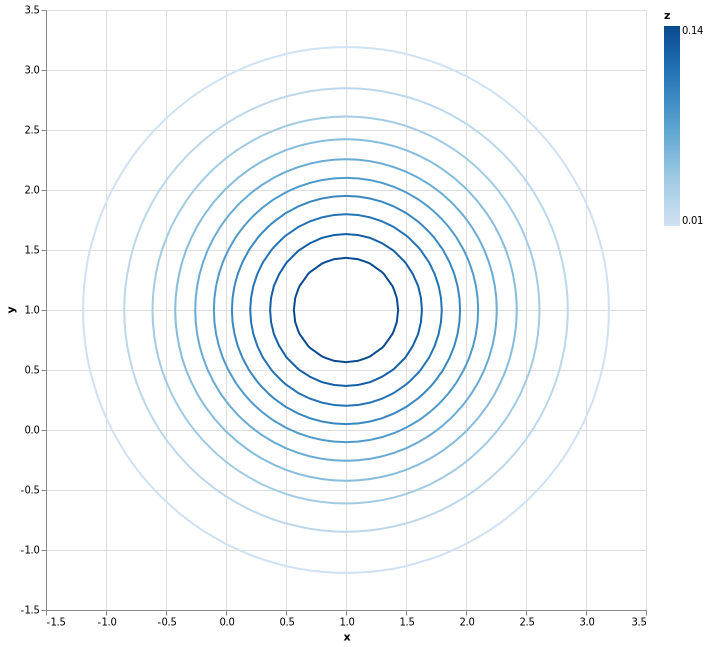

In [8]:
@vlplot(width=600,height=600,data=df,:line,x=:x,y=:y,color={:z,type="q"},order ={field =:row, type=:q })

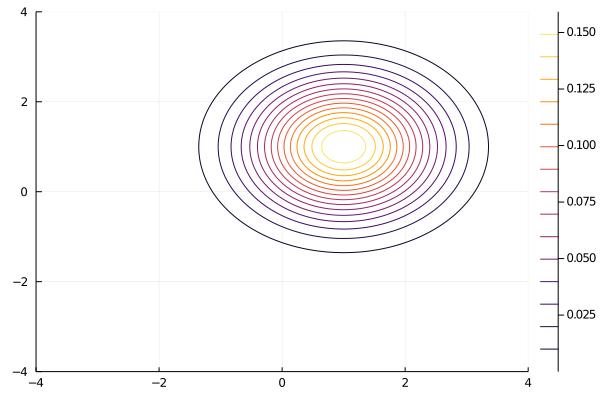

In [9]:
y = -4:0.05:4
x = -4:0.05:4
plt.contour(x,y,fmv)

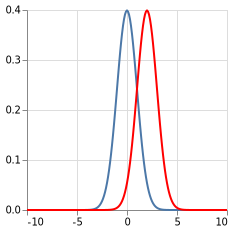

In [25]:
m = 2
x = collect(-10:0.1:10)
μ = Normal()
ν = Normal(m)
y = pdf(μ,x)
z = pdf(ν,x)
v1 = @vlplot(:line,x={x,type="quantitative"},y={y,type="quantitative"})
v2 = @vlplot(:line,x={x,type="quantitative"},y={z,type="quantitative"},color={value="red"})
p1 = @vlplot()+v1 + v2

In [11]:
kldivergence([0.3],[0.1])
kl(μ,ν,x) = kldivergence(pdf(μ,x),pdf(ν,x))
kl(Normal(1),Normal(),x)
kl_divergence(pdf(ν,x),pdf(μ,x))

19.99999999999994

In [23]:
domain = 30
x = collect(-domain:0.1:domain*2)
kl(μ,ν,x) = kldivergence(pdf(μ,x),pdf(ν,x))
df = Array{Float64}(undef, 0, 4)
pf = Array{Float64}(undef, 0, 4)
for m = 0:1:domain
    μ  = Normal(0,3)
    ν  = Normal(m,3)
    y  = pdf(μ,x)
    z  = pdf(ν,x)
    w  = round(w1d2(μ,ν)[1];digits=2)
    dkl = kldivergence(y,(z+y)/2)
    jkl= dkl/2 + kldivergence(z,(z+y)/2)
    df = vcat(df,[m w dkl jkl])
    if (m % 10 == 0) && (m>0)
        pf = vcat(pf,[x y z ones(length(x))*m])
    end
end
df = DataFrame(m = df[:,1], w = df[:, 2], kl = df[:,3], jkl = df[:, 4]);
pf = DataFrame(x = pf[:,1], y = pf[:, 2], z = pf[:,3], m=pf[:,4]);

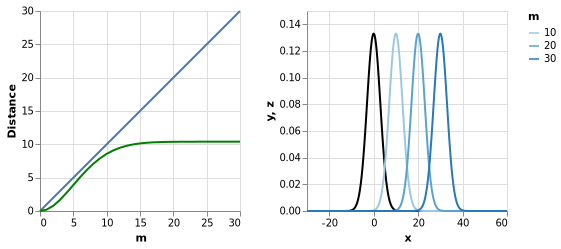

In [24]:
v1 = @vlplot(data=df,:line,x={:m,type="quantitative"},y={:w,type="quantitative",title="Distance"})
v2 = @vlplot(data=df,:line,x={:m,type="quantitative"},y={:jkl,type="quantitative"},color={value="green"})
p1  = @vlplot() + v1 + v2
v3  = @vlplot(data=pf,:line,x={:x,type="quantitative"},y={:y, type="quantitative"},color={"value"="black"})
v4  = @vlplot(data=pf,:line,x={:x,type="quantitative"},y={:z, type="quantitative"},color={:m,type="ordinal"})
p2 = @vlplot() + v3 + v4
[p1 p2]

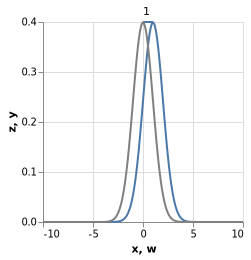

In [16]:
df = Array{Float64}(undef, 0, 5)
for m = 0:1:10
    x = collect(-10:0.1:10)
    μ = Normal()
    ν = Normal(m)
    y = pdf(μ,x)
    z = pdf(ν,x)
    mu = ones(length(x))*m
    w = round(w1d2(μ,ν)[1];digits=2)
    w = ones(length(x))*w
    w[1] = 0
    df= vcat(df,[x y z mu w])
end
df = DataFrame(x = df[:,1], y = df[:, 2], z = df[:,3], mu=df[:, 4], w = df[:,5]);
v1 = @vlplot(
    hconcat=[{
    data=df,
    layer=[{
    selection ={
    "Mu"= {
        "type"= "single",
        "fields"= ["mu"],
        "init"={"mu"=1},
        "bind"= {
            "mu"= {"input"= "range", "min"= 0,"max"= 10,"step"= 1},
            }}},
    transform = [{filter={selection="Mu"}}],
    mark=:line,
    x={:x,type="quantitative"},
    y={:z,type="quantitative"}
            },
    {
    transform = [{filter={selection="Mu"}}],
    mark=:line,
    x={:w,type="quantitative"},
    y={value=0}
                        },
    {
    transform = [{filter={selection="Mu"}}],
    mark={type="text",align="left",dx=0},
    y={value=-10},
    text={field=:w,type="nominal",aggregate="max"}
                            },
    {
    mark=:line,
    x={:x,type="quantitative"},y={:y,type="quantitative"},color={"value"="gray"}
                                        }]
                            }]
    )

In [16]:
x = collect(-10:0.1:30)
μ = Normal()
ν = Normal(10)
y = pdf(μ,x)
z = pdf(ν,x)
μ = DataFrame(x=x,y=y,mu="μ")
ν = DataFrame(x=x,y=z,mu="ν")
append!(μ,ν);

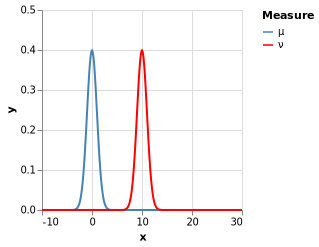

In [17]:
v1 = @vlplot(mark="line",data=μ,x={:x,type="quantitative"},
        y={:y,type="quantitative",scale={domain=[0,0.5]}},
        color={:mu,type="nominal",title="Measure",scale={range=["#4682b4","red"]}})

In [18]:
x = collect(-10:0.1:30)
μ = Normal()
ν = Normal(20)
y = pdf(μ,x)
z = pdf(ν,x)
μ = DataFrame(x=x,y=y,mu="μ")
ν = DataFrame(x=x,y=z,mu="ν")
append!(μ,ν);


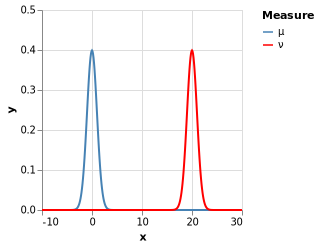

In [19]:
v2 = @vlplot(mark="line",data=μ,x={:x,type="quantitative"},
        y={:y,type="quantitative",scale={domain=[0,0.5]}},
        color={:mu,type="nominal",title="Measure",scale={range=["#4682b4","red"]}})

In [21]:
# p = [v1 v2]
# VegaLite.savefig("../Phd_Proposal/Figures/ground_geometry.svg",p)

### Barycenter

5-element Array{Float64,1}:
  3.1463519251893333
  3.816164616573016
 -1.7376396728293029
  1.1253228779135172
 -0.5933700599671397

In [142]:
nb = 5
x = collect(-5:0.1:5)
ms= rand(Normal(0,1.5),nb)
μ = Normal()
y = zeros(size(x)[1],nb)
i = 1
means = []
xx =[]
eb = zeros(size(x)[1])
for m in ms
    y[:,i] = pdf(Normal(m),x)
    eb = eb + pdf(Normal(m),x)
    i+=1
    push!(means,ones(size(x)[1])*m)
    push!(xx,x)
end
means = collect(Iterators.flatten(means))
xx    = collect(Iterators.flatten(xx))
y     = vcat(y...)
eb    = eb ./ 5
wb    = pdf(Normal(mean(ms)),x)

df   = DataFrame(x=xx,y=y,m=means);
μ = DataFrame(x=x,y=eb,mu="Euclidean Average")
ν = DataFrame(x=x,y=wb,mu="Wasserstein Barycenter")
append!(μ,ν);

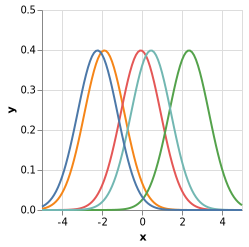

In [152]:
p1 = @vlplot(mark="line",data=df,x={:x,type="quantitative"},
        y={:y,type="quantitative",scale={domain=[0,0.5]}},
        color={:m,type="nominal",legend=nothing,scale={scheme="tableau10"}})

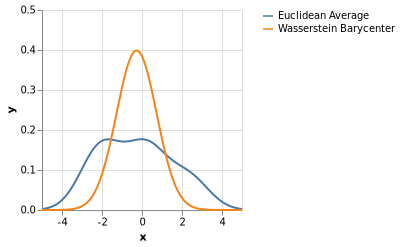

In [157]:
p2 = @vlplot(mark="line",data=μ,x={:x,type="quantitative"},
        y={:y,type="quantitative",scale={domain=[0,0.5]}},
        color={:mu,type="nominal",legend={title=nothing},scale={scheme="tableau10"}})